TEAM MEMBERS: Anthea Abreo (AXA210122), Adannah Duruoha (AXD180037), Terisha Prax (TXK220031), Samyak Rokade (SJR220000)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import progressbar

from sklearn.metrics import log_loss, mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# **Data Preprocessing**

In [ ]:
dataset = pd.read_csv("https://raw.githubusercontent.com/tkolencherry/ML_Project_2023/main/Traffic.csv")

In [ ]:
dataset.corr()

<ipython-input-4-c187c74d1e71>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dataset.corr()


,Date,CarCount,BikeCount,BusCount,TruckCount,Total
Date,1.000000,-0.013453,-0.005089,-0.015536,0.024734,-0.010679
CarCount,-0.013453,1.000000,0.722539,0.692994,-0.628157,0.970443
BikeCount,-0.005089,0.722539,1.000000,0.566364,-0.575399,0.797429
BusCount,-0.015536,0.692994,0.566364,1.000000,-0.546931,0.790705
TruckCount,0.024734,-0.628157,-0.575399,-0.546931,1.000000,-0.555471
Total,-0.010679,0.970443,0.797429,0.790705,-0.555471,1.000000


In [ ]:
dataset = dataset.drop(["Time"],axis=1)

In [ ]:
dataset

,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
0,10,Tuesday,31,0,4,4,39,low
1,10,Tuesday,49,0,3,3,55,low
2,10,Tuesday,46,0,3,6,55,low
3,10,Tuesday,51,0,2,5,58,low
4,10,Tuesday,57,6,15,16,94,normal
...,...,...,...,...,...,...,...,...
2971,9,Thursday,16,3,1,36,56,normal
2972,9,Thursday,11,0,1,30,42,normal
2973,9,Thursday,15,4,1,25,45,normal
2974,9,Thursday,16,5,0,27,48,normal


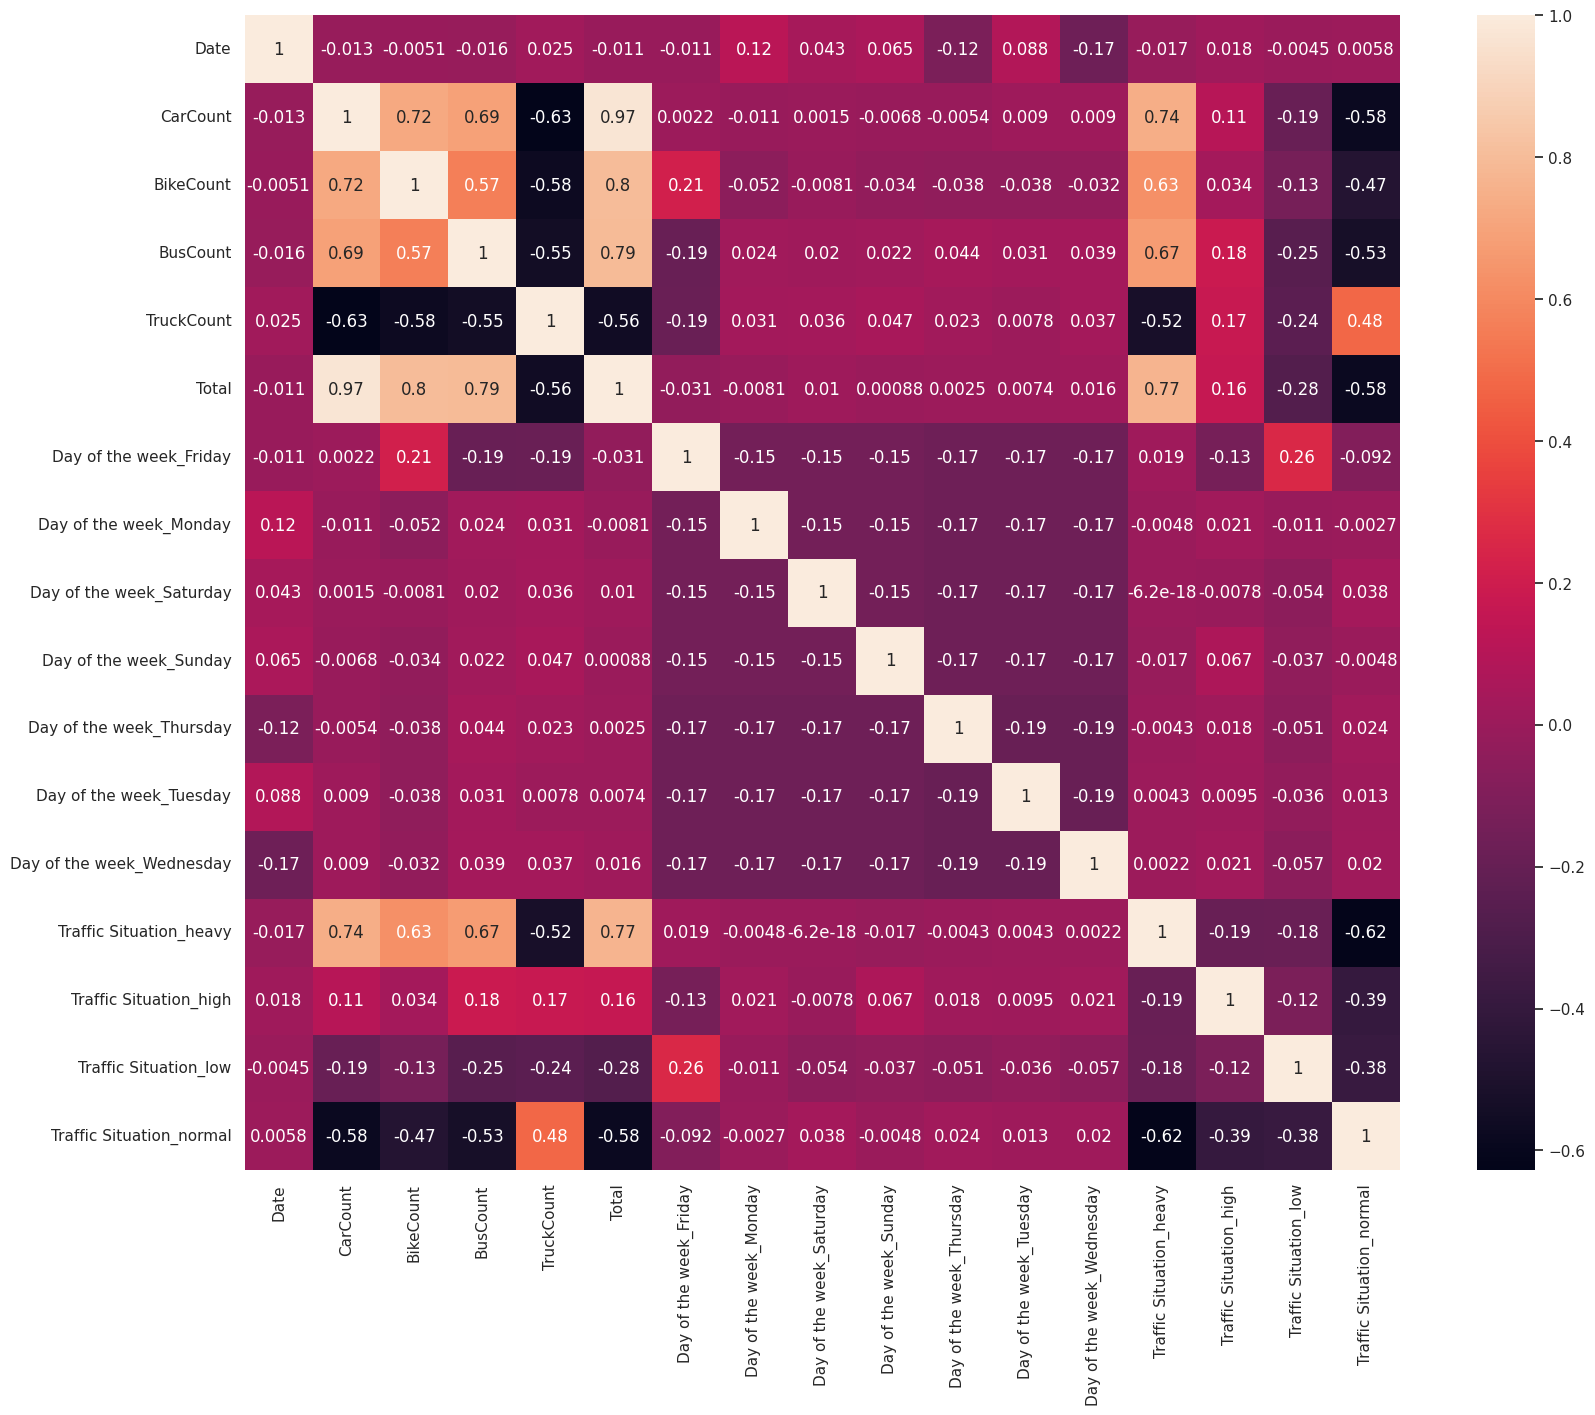

In [ ]:
cleanedDataset = pd.get_dummies(dataset)
sns.set(rc = {"figure.figsize":(20,15)})
sns.heatmap(cleanedDataset.corr(),annot=True,square=True)
plt.show()

In [ ]:
dataset['Day'] = dataset['Day of the week'].map({'Sunday': 0, 'Monday': 1, 'Tuesday': 2, 'Wednesday': 3,'Thursday': 4,'Friday': 5,'Saturday': 6,})


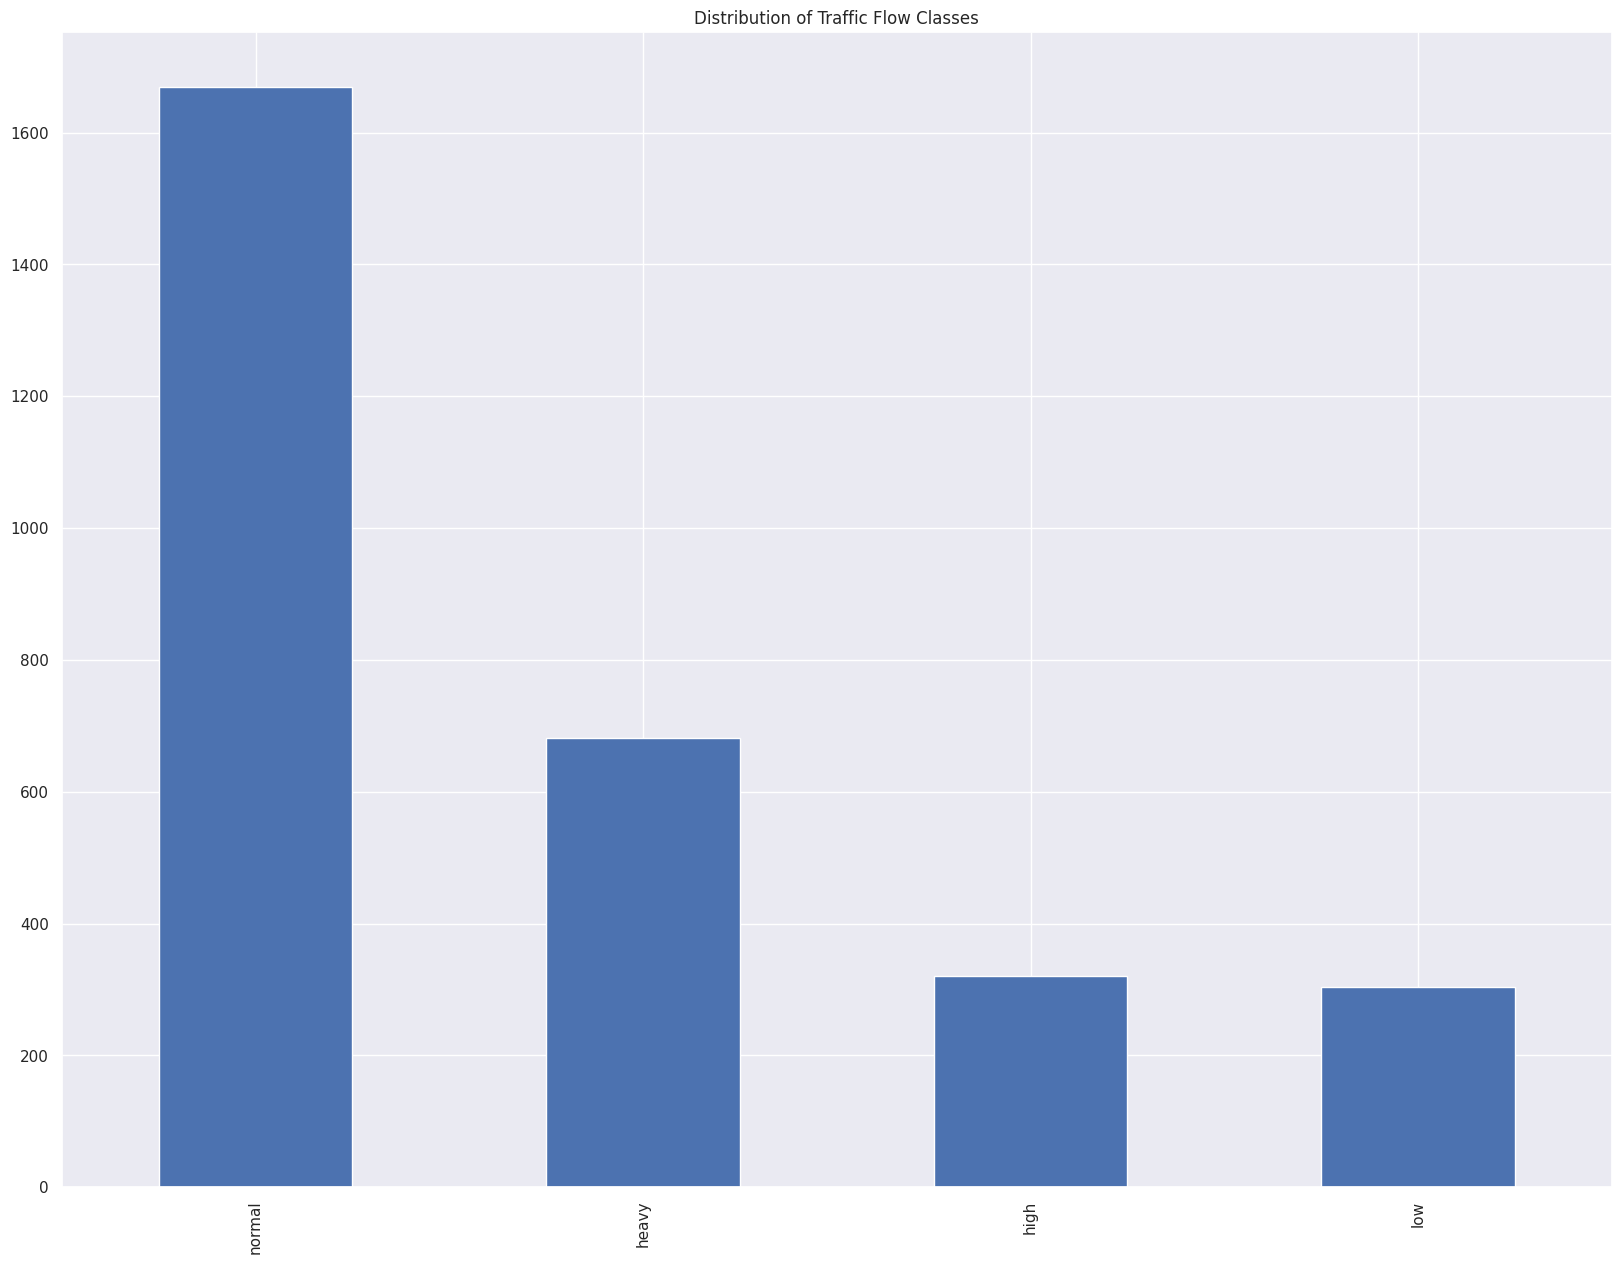

In [ ]:
w = dataset['Traffic Situation'].value_counts().plot(kind = 'bar', title = "Distribution of Traffic Flow Classes")

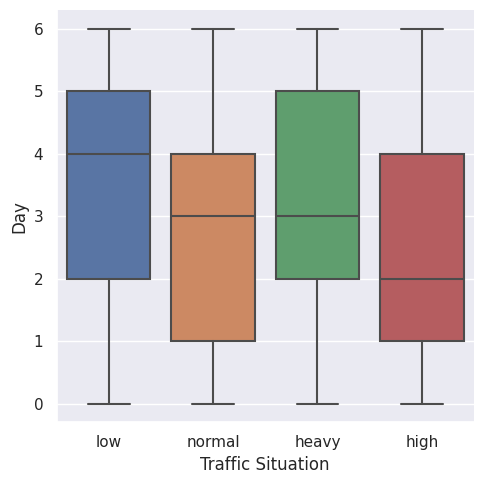

In [ ]:
p = sns.catplot(data=dataset, x="Traffic Situation", y="Day", kind="box")

<Axes: xlabel='TruckCount', ylabel='Traffic Situation'>

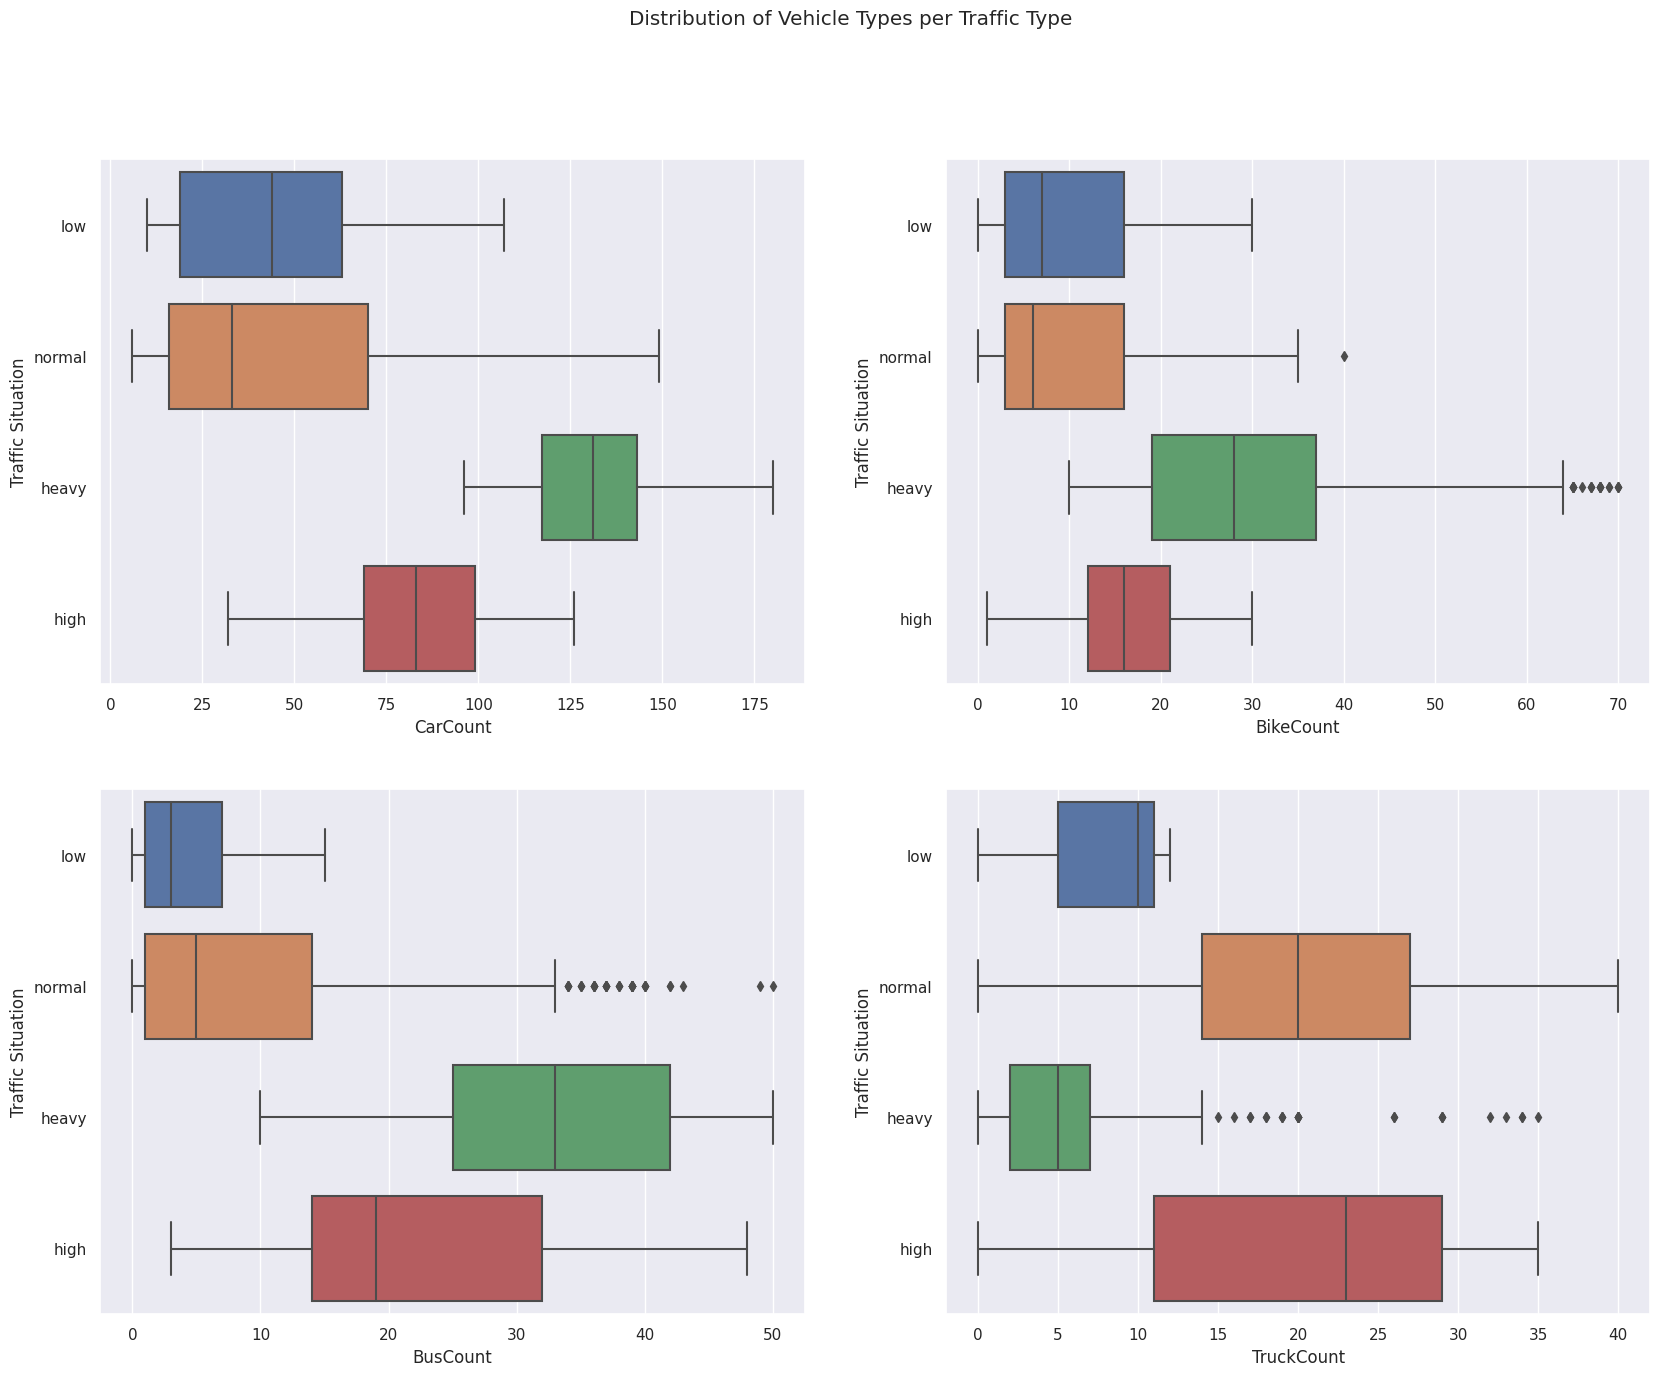

In [ ]:
fig, axes = plt.subplots(2,2)
fig.suptitle('Distribution of Vehicle Types per Traffic Type')

sns.boxplot(ax = axes[0,0], data = dataset, x = "CarCount", y= "Traffic Situation")
sns.boxplot(ax = axes[0,1], data = dataset, x = "BikeCount", y= "Traffic Situation")
sns.boxplot(ax = axes[1,0], data = dataset, x = "BusCount", y= "Traffic Situation")
sns.boxplot(ax = axes[1,1], data = dataset, x = "TruckCount", y= "Traffic Situation")


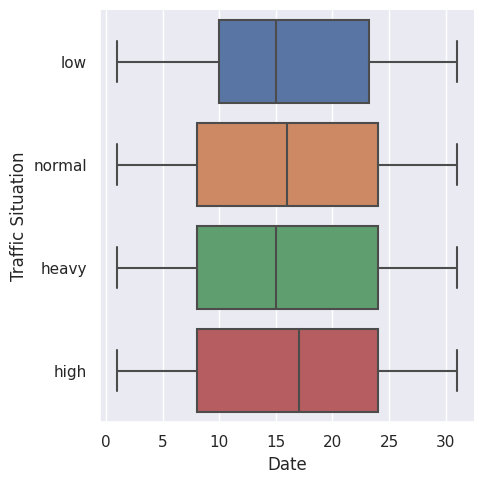

In [ ]:
p = sns.catplot(data=dataset, x="Date", y="Traffic Situation", kind="box")

Split Data into Predictors and Response

In [ ]:
X = dataset[[ 'Date', 'Day', 'CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total']]
dataset['Trafficst'] = dataset['Traffic Situation'].map({'low': 0, 'normal': 1, 'high': 2, 'heavy': 3})
y_strat = dataset['Traffic Situation']
Y = np.eye(4)[dataset['Trafficst']]

In [ ]:
X

,Date,Day,CarCount,BikeCount,BusCount,TruckCount,Total
0,10,2,31,0,4,4,39
1,10,2,49,0,3,3,55
2,10,2,46,0,3,6,55
3,10,2,51,0,2,5,58
4,10,2,57,6,15,16,94
...,...,...,...,...,...,...,...
2971,9,4,16,3,1,36,56
2972,9,4,11,0,1,30,42
2973,9,4,15,4,1,25,45
2974,9,4,16,5,0,27,48


In [ ]:
Y

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]])

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1, stratify = y_strat)

# **The Model: Custom Gradient Boost**

In [ ]:
from sklearn.base import BaseEstimator,ClassifierMixin

In [ ]:
class CustomGBClassifier(BaseEstimator,ClassifierMixin):
    def __init__(self, num_trees=200, alpha=.5, min_samples_split=2,
                 min_info_gain=1e-7, max_depth=2):
        self.num_trees = num_trees
        self.max_depth = max_depth
        self.alpha = alpha
        self.min_impurity = min_info_gain
        self.min_samples_split = min_samples_split


        self.progress_bar = progressbar.ProgressBar(widgets=['Training: ', progressbar.Percentage(), ' ', progressbar.Bar(marker="-", left="[", right="]"),' ', progressbar.ETA()])
        self.estimators = []
        for _ in range(num_trees):
            sub_tree = DecisionTreeRegressor(
                    min_samples_split=self.min_samples_split,
                    min_impurity_decrease=self.min_impurity,
                    max_depth=self.max_depth)
            self.estimators.append(sub_tree)


    def predict(self, features):
      predictions = np.array([])
      for tree_model in self.estimators:
          cur_pred = tree_model.predict(features)
          cur_pred = np.multiply(self.alpha, cur_pred)
          predictions = -cur_pred if not predictions.any() else predictions - cur_pred

      exponentiated_predictions = np.exp(predictions)
      normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
      final_predictions = np.argmax(normalized_predictions, axis=1)
      return final_predictions


    def fit(self, features, labels):
      predicted_labels = np.full(np.shape(labels), np.mean(labels, axis=0))
      for tree_index in self.progress_bar(range(self.num_trees)):
          predicted_labels = np.clip(predicted_labels, 1e-8, 1 - 1e-8)
          error_gradient = - (labels / predicted_labels) + (1 - labels) / (1 - predicted_labels)
          self.estimators[tree_index].fit(features, error_gradient)
          predictions = self.estimators[tree_index].predict(features)
          predicted_labels -= np.multiply(self.alpha, predictions)

    def score(self,y_pred,y_test):
      return accuracy_score(y_pred,np.argmax(y_test, axis=1))


# **Training and Testing the Model**

In [ ]:
GBCModel = CustomGBClassifier(num_trees=10,
                                      min_samples_split=10,
                                      alpha=.5,
                                      max_depth=8,
                                      min_info_gain=1e-2
                                      )

In [ ]:
GBCModel.fit(X_train,y_train)

Training: 100% [-----------------------------------------------] Time:  0:00:00


In [ ]:
y_pred = GBCModel.predict(X_test)

<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)


In [ ]:
y_pred[0:10]

array([1, 1, 0, 0, 1, 1, 3, 0, 1, 1])

In [ ]:
accuracy_score(y_pred,np.argmax(y_test, axis=1))

1.0

## **Testing the model for different parameter values**

In [ ]:
alpha = [round(i,2) for i in np.arange(0.1,1.1,0.1)]
num_trees = [i for i in range(5,15)]
bestParam = None
maxAcc = 0
accuracy_data = []
for a in alpha:
  for n in num_trees:
    GBCModel = CustomGBClassifier(num_trees=n,min_samples_split=10,alpha=a,max_depth=8,min_info_gain=1e-2)
    GBCModel.fit(X_train,y_train)
    y_pred = GBCModel.predict(X_test)
    acc = accuracy_score(y_pred,np.argmax(y_test, axis=1))
    print("alpha= ", a, "num_trees = ", n, "accuracy = ", acc)
    accuracy_data.append({'alpha': a, 'num_trees': n, 'accuracy':acc})
    if acc> maxAcc:
      bestParam = [a,n]
      maxAcc = acc
    print(bestParam,maxAcc)

accuracy_df = pd.DataFrame(accuracy_data)

Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  

alpha=  0.1 num_trees =  5 accuracy =  0.9988801791713325
[0.1, 5] 0.9988801791713325
alpha=  0.1 num_trees =  6 accuracy =  0.9988801791713325
[0.1, 5] 0.9988801791713325
alpha= 

Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training:  66% [-------------------------------                ] ETA:   0:00:00

 0.1 num_trees =  7 accuracy =  0.9988801791713325
[0.1, 5] 0.9988801791713325
alpha=  0.1 num_trees =  8 accuracy =  1.0
[0.1, 8] 1.0


Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training:  45% [---------------------                          ] ETA:   0:00:00

alpha=  0.1 num_trees =  9 accuracy =  0.9988801791713325
[0.1, 8] 1.0
alpha=  0.1 num_trees =  10 accuracy =  0.9988801791713325
[0.1, 8] 1.0


Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training:   0% [                                               ] ETA:  --:--:--

alpha=  0.1 num_trees =  11 accuracy =  0.9988801791713325
[0.1, 8] 1.0
alpha=  0.1 num_trees =  12 accuracy =  0.9988801791713325
[0.1, 8] 1.0


Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training:   0% [                                               ] ETA:  --:--:--

alpha=  0.1 num_trees =  13 accuracy =  0.9988801791713325
[0.1, 8] 1.0
alpha=  0.1 num_trees =  14 accuracy =  0.9988801791713325
[0.1, 8] 1.0


Training: 100% [-----------------------------------------------] Time:  0:00:00
Training: 100% [-----------------------------------------------] Time:  0:00:00
Training: 100% [-----------------------------------------------] Time:  0:00:00
Training:   0% [                                               ] ETA:  --:--:--

alpha=  0.2 num_trees =  5 accuracy =  0.9988801791713325
[0.1, 8] 1.0
alpha=  0.2 num_trees =  6 accuracy =  1.0
[0.1, 8] 1.0
alpha=  0.2 num_trees =  7 accuracy =  1.0
[0.1, 8] 1.0


Training: 100% [-----------------------------------------------] Time:  0:00:00
Training: 100% [-----------------------------------------------] Time:  0:00:00
Training:  60% [----------------------------                   ] ETA:   0:00:00

alpha=  0.2 num_trees =  8 accuracy =  1.0
[0.1, 8] 1.0
alpha=  0.2 num_trees =  9 accuracy =  0.9988801791713325
[0.1, 8] 1.0


Training: 100% [-----------------------------------------------] Time:  0:00:00
Training: 100% [-----------------------------------------------] Time:  0:00:00
Training:  58% [---------------------------                    ] ETA:   0:00:00

alpha=  0.2 num_trees =  10 accuracy =  0.9988801791713325
[0.1, 8] 1.0
alpha=  0.2 num_trees =  11 accuracy =  0.9988801791713325
[0.1, 8] 1.0


Training: 100% [-----------------------------------------------] Time:  0:00:00
Training: 100% [-----------------------------------------------] Time:  0:00:00
Training:   0% [                                               ] ETA:  --:--:--

alpha=  0.2 num_trees =  12 accuracy =  1.0
[0.1, 8] 1.0
alpha=  0.2 num_trees =  13 accuracy =  1.0
[0.1, 8] 1.0


Training: 100% [-----------------------------------------------] Time:  0:00:00
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training:   0% [                                               ] ETA:  --:--:--

alpha=  0.2 num_trees =  14 accuracy =  1.0
[0.1, 8] 1.0
alpha=  0.3 num_trees =  5 accuracy =  1.0
[0.1, 8] 1.0
alpha=  0.3 num_trees =  6 accuracy =  1.0
[0.1, 8] 1.0


Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00


alpha=  0.3 num_trees =  7 accuracy =  1.0
[0.1, 8] 1.0
alpha=  0.3 num_trees =  8 accuracy =  1.0
[0.1, 8] 1.0


<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training:  63% [-----------------------------                  ] ETA:   0:00:00

alpha=  0.3 num_trees =  9 accuracy =  1.0
[0.1, 8] 1.0
alpha=  0.3 num_trees =  10 accuracy =  1.0
[0.1, 8] 1.0


Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training:  53% [-------------------------                      ] ETA:   0:00:00

alpha=  0.3 num_trees =  11 accuracy =  1.0
[0.1, 8] 1.0
alpha=  0.3 num_trees =  12 accuracy =  1.0
[0.1, 8] 1.0


Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00


alpha=  0.3 num_trees =  13 accuracy =  1.0
[0.1, 8] 1.0
alpha=  0.3 num_trees =  14 accuracy =  1.0
[0.1, 8] 1.0
alpha= 

<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:

 0.4 num_trees =  5 accuracy =  0.9988801791713325
[0.1, 8] 1.0
alpha=  0.4 num_trees =  6 accuracy =  0.9988801791713325
[0.1, 8] 1.0
alpha=  0.4 num_trees =  7 accuracy =  0.9988801791713325
[0.1, 8] 1.0


Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00


alpha=  0.4 num_trees =  8 accuracy =  0.9988801791713325
[0.1, 8] 1.0
alpha=  0.4 num_trees =  9 accuracy =  0.9988801791713325
[0.1, 8] 1.0


<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training:  50% [-----------------------                        ] ETA:   0:00:00

alpha=  0.4 num_trees =  10 accuracy =  0.9988801791713325
[0.1, 8] 1.0
alpha=  0.4 num_trees =  11 accuracy =  0.9988801791713325
[0.1, 8] 1.0


Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training:  42% [--------------------                           ] ETA:   0:00:00

alpha=  0.4 num_trees =  12 accuracy =  0.9988801791713325
[0.1, 8] 1.0
alpha=  0.4 num_trees =  13 accuracy =  0.9988801791713325
[0.1, 8] 1.0


Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  

alpha=  0.4 num_trees =  14 accuracy =  0.9988801791713325
[0.1, 8] 1.0
alpha=  0.5 num_trees =  5 accuracy =  1.0
[0.1, 8] 1.0
alpha=  0.5 num_trees =  6 accuracy =  1.0
[0.1, 8] 1.0


Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  

alpha=  0.5 num_trees =  7 accuracy =  1.0
[0.1, 8] 1.0
alpha=  0.5 num_trees =  8 accuracy =  1.0
[0.1, 8] 1.0
alpha=  0.5 num_trees =  9 accuracy =  1.0
[0.1, 8] 1.0


Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training:  50% [-----------------------                        ] ETA:   0:00:00

alpha=  0.5 num_trees =  10 accuracy =  1.0
[0.1, 8] 1.0
alpha=  0.5 num_trees =  11 accuracy =  1.0
[0.1, 8] 1.0


Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training:  71% [---------------------------------              ] ETA:   0:00:00

alpha=  0.5 num_trees =  12 accuracy =  1.0
[0.1, 8] 1.0
alpha=  0.5 num_trees =  13 accuracy =  1.0
[0.1, 8] 1.0


Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  

alpha=  0.5 num_trees =  14 accuracy =  1.0
[0.1, 8] 1.0
alpha=  0.6 num_trees =  5 accuracy =  0.9988801791713325
[0.1, 8] 1.0
alpha=  0.6 num_trees =  6 accuracy =  0.9988801791713325
[0.1, 8] 1.0
alpha=  0.6 num_trees =  7 accuracy =  0.9988801791713325
[0.1, 8] 1.0


Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  

alpha=  0.6 num_trees =  8 accuracy =  0.9988801791713325
[0.1, 8] 1.0
alpha=  0.6 num_trees =  9 accuracy =  0.9988801791713325
[0.1, 8] 1.0
alpha=  0.6 num_trees =  10 accuracy =  0.9988801791713325
[0.1, 8] 1.0


Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00


alpha=  0.6 num_trees =  11 accuracy =  0.9988801791713325
[0.1, 8] 1.0
alpha=  0.6 num_trees =  12 accuracy =  0.9988801791713325
[0.1, 8] 1.0


<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:

alpha=  0.6 num_trees =  13 accuracy =  0.9988801791713325
[0.1, 8] 1.0
alpha=  0.6 num_trees =  14 accuracy =  0.9988801791713325
[0.1, 8] 1.0
alpha=  0.7 num_trees =  5 accuracy =  0.9988801791713325
[0.1, 8] 1.0


Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  

alpha=  0.7 num_trees =  6 accuracy =  0.9988801791713325
[0.1, 8] 1.0
alpha=  0.7 num_trees =  7 accuracy =  0.9988801791713325
[0.1, 8] 1.0
alpha=  0.7 num_trees =  8 accuracy =  0.9988801791713325
[0.1, 8] 1.0


Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  

alpha=  0.7 num_trees =  9 accuracy =  0.9988801791713325
[0.1, 8] 1.0
alpha=  0.7 num_trees =  10 accuracy =  0.9988801791713325
[0.1, 8] 1.0
alpha=  0.7 num_trees =  11 accuracy =  0.9988801791713325
[0.1, 8] 1.0


Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training:  57% [--------------------------                     ] ETA:   0:00:00

alpha=  0.7 num_trees =  12 accuracy =  0.9988801791713325
[0.1, 8] 1.0
alpha=  0.7 num_trees =  13 accuracy =  0.9988801791713325
[0.1, 8] 1.0


Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  

alpha=  0.7 num_trees =  14 accuracy =  0.9988801791713325
[0.1, 8] 1.0
alpha=  0.8 num_trees =  5 accuracy =  0.9988801791713325
[0.1, 8] 1.0
alpha=  0.8 num_trees =  6 accuracy =  1.0
[0.1, 8] 1.0
alpha=  0.8 num_trees =  7 accuracy =  1.0
[0.1, 8] 1.0


Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  

alpha=  0.8 num_trees =  8 accuracy =  1.0
[0.1, 8] 1.0
alpha=  0.8 num_trees =  9 accuracy =  1.0
[0.1, 8] 1.0
alpha=  0.8 num_trees =  10 accuracy =  1.0
[0.1, 8] 1.0


Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00


alpha=  0.8 num_trees =  11 accuracy =  1.0
[0.1, 8] 1.0
alpha=  0.8 num_trees =  12 accuracy =  1.0
[0.1, 8] 1.0


<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:

alpha=  0.8 num_trees =  13 accuracy =  1.0
[0.1, 8] 1.0
alpha=  0.8 num_trees =  14 accuracy =  1.0
[0.1, 8] 1.0
alpha=  0.9 num_trees =  5 accuracy =  1.0
[0.1, 8] 1.0



<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>

alpha=  0.9 num_trees =  6 accuracy =  1.0
[0.1, 8] 1.0
alpha=  0.9 num_trees =  7 accuracy =  1.0
[0.1, 8] 1.0
alpha=  0.9 num_trees =  8 accuracy =  1.0
[0.1, 8] 1.0


<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:

alpha=  0.9 num_trees =  9 accuracy =  1.0
[0.1, 8] 1.0
alpha=  0.9 num_trees =  10 accuracy =  1.0
[0.1, 8] 1.0
alpha=  0.9 num_trees =  11 accuracy =  1.0
[0.1, 8] 1.0


Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training:  64% [------------------------------                 ] ETA:   0:00:00

alpha=  0.9 num_trees =  12 accuracy =  1.0
[0.1, 8] 1.0
alpha=  0.9 num_trees =  13 accuracy =  1.0
[0.1, 8] 1.0


Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  

alpha=  0.9 num_trees =  14 accuracy =  1.0
[0.1, 8] 1.0
alpha=  1.0 num_trees =  5 accuracy =  0.9944008958566629
[0.1, 8] 1.0
alpha=  1.0 num_trees =  6 accuracy =  0.9955207166853304
[0.1, 8] 1.0
alpha=  1.0 num_trees =  7 accuracy =  0.9977603583426652
[0.1, 8] 1.0


Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  

alpha=  1.0 num_trees =  8 accuracy =  0.9932810750279956
[0.1, 8] 1.0
alpha=  1.0 num_trees =  9 accuracy =  0.9944008958566629
[0.1, 8] 1.0
alpha=  1.0 num_trees =  10 accuracy =  0.9977603583426652
[0.1, 8] 1.0


Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training:  61% [----------------------------                   ] ETA:   0:00:00

alpha=  1.0 num_trees =  11 accuracy =  0.9977603583426652
[0.1, 8] 1.0
alpha=  1.0 num_trees =  12 accuracy =  0.9944008958566629
[0.1, 8] 1.0


Training: 100% [-----------------------------------------------] Time:  0:00:00
<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)
Training: 100% [-----------------------------------------------] Time:  0:00:00


alpha=  1.0 num_trees =  13 accuracy =  0.9977603583426652
[0.1, 8] 1.0
alpha=  1.0 num_trees =  14 accuracy =  0.9977603583426652
[0.1, 8] 1.0


<ipython-input-18-bacd100b0bac>:28: RuntimeWarning: overflow encountered in exp
  exponentiated_predictions = np.exp(predictions)
<ipython-input-18-bacd100b0bac>:29: RuntimeWarning: invalid value encountered in divide
  normalized_predictions = exponentiated_predictions / np.expand_dims(np.sum(exponentiated_predictions, axis=1), axis=1)


In [ ]:
display(accuracy_df)

,alpha,num_trees,accuracy
0,0.1,5,0.998880
1,0.1,6,0.998880
2,0.1,7,0.998880
3,0.1,8,1.000000
4,0.1,9,0.998880
...,...,...,...
95,1.0,10,0.997760
96,1.0,11,0.997760
97,1.0,12,0.994401
98,1.0,13,0.997760


## **Model Evaluation**

In [ ]:
labelConfMatrix =[]
for n in range(0,4):
  conf_matrix = {"TP":0,"TN":0,"FP":0,"FN":0}
  for i,j in zip(np.argmax(y_test,axis=1),y_pred):
    if i == n: #if the true value is i
      if i == j: #if the pred value is also i
        conf_matrix["TP"]+=1
      elif i!=j:
        conf_matrix["FP"]+=1
    elif i!=n:
      if i==j:
        conf_matrix["TN"]+=1
      elif i!=j:
        conf_matrix["FN"]+=1
  labelConfMatrix.append(conf_matrix)

In [ ]:
label_names = [0, 1, 2, 3]
confusion_df = pd.DataFrame(labelConfMatrix, index=label_names)
print(confusion_df)

    TP   TN  FP  FN
0   90  801   1   1
1  501  390   0   2
2   96  795   0   2
3  204  687   1   1


In [ ]:
for i, conf_matrix in enumerate(labelConfMatrix):
    TP = conf_matrix["TP"]
    TN = conf_matrix["TN"]
    FP = conf_matrix["FP"]
    FN = conf_matrix["FN"]

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    if ((precision + recall) != 0):
      f_score = 2*(precision * recall)/(precision + recall)
    else:
      f_score = 0

    confusion_df.at[label_names[i], 'Accuracy'] = accuracy
    confusion_df.at[label_names[i], 'Precision'] = precision
    confusion_df.at[label_names[i], 'Recall'] = recall
    confusion_df.at[label_names[i], 'F-Score'] = f_score

print("Class-wise")
print(confusion_df,"\n")
print("Mulitclass Confusion matrix")
print(confusion_matrix(y_pred,np.argmax(y_test,axis=1)),"\n")
print("Classification Report")
print(classification_report(y_pred,np.argmax(y_test,axis=1)))

Class-wise
    TP   TN  FP  FN  Accuracy  Precision    Recall   F-Score
0   90  801   1   1   0.99776   0.989011  0.989011  0.989011
1  501  390   0   2   0.99776   1.000000  0.996024  0.998008
2   96  795   0   2   0.99776   1.000000  0.979592  0.989691
3  204  687   1   1   0.99776   0.995122  0.995122  0.995122 

Mulitclass Confusion matrix
[[ 90   0   0   0]
 [  1 501   0   1]
 [  0   0  96   0]
 [  0   0   0 204]] 

Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        90
           1       1.00      1.00      1.00       503
           2       1.00      1.00      1.00        96
           3       1.00      1.00      1.00       204

    accuracy                           1.00       893
   macro avg       1.00      1.00      1.00       893
weighted avg       1.00      1.00      1.00       893



# Logistic Regression Comparison

In [ ]:
x_lr = dataset.drop(columns = ['Traffic Situation', 'Day of the week'])
y_lr = dataset['Traffic Situation']
x_lr.head()

,Date,CarCount,BikeCount,BusCount,TruckCount,Total,Day,Trafficst
0,10,31,0,4,4,39,2,0
1,10,49,0,3,3,55,2,0
2,10,46,0,3,6,55,2,0
3,10,51,0,2,5,58,2,0
4,10,57,6,15,16,94,2,1


In [ ]:
xlr_train, xlr_test, ylr_train, ylr_test = train_test_split(x_lr, y_lr, test_size=0.2, random_state=42, stratify = Y)
lr = LogisticRegression(multi_class = 'ovr', solver = 'liblinear') #ovr is one versus rest
lr.fit(xlr_train,ylr_train)

yhat_lr = lr.predict(xlr_test)
print("Logistic Regression Training Accuracy : ", lr.score(xlr_train, ylr_train))
print("Logistic Regression Testing Accuracy : ", lr.score(xlr_test, ylr_test), "\n")

cm_lr = confusion_matrix(ylr_test, yhat_lr)
print("Confusion Matrix \n", cm_lr, "\n")
print("Classification Report \n", classification_report(ylr_test, yhat_lr))


Logistic Regression Training Accuracy :  0.8974789915966387
Logistic Regression Testing Accuracy :  0.8976510067114094 

Confusion Matrix 
 [[136   1   0   0]
 [ 17   5   0  42]
 [  0   0  61   0]
 [  0   1   0 333]] 

Classification Report 
               precision    recall  f1-score   support

       heavy       0.89      0.99      0.94       137
        high       0.71      0.08      0.14        64
         low       1.00      1.00      1.00        61
      normal       0.89      1.00      0.94       334

    accuracy                           0.90       596
   macro avg       0.87      0.77      0.75       596
weighted avg       0.88      0.90      0.86       596



KNN Comparison

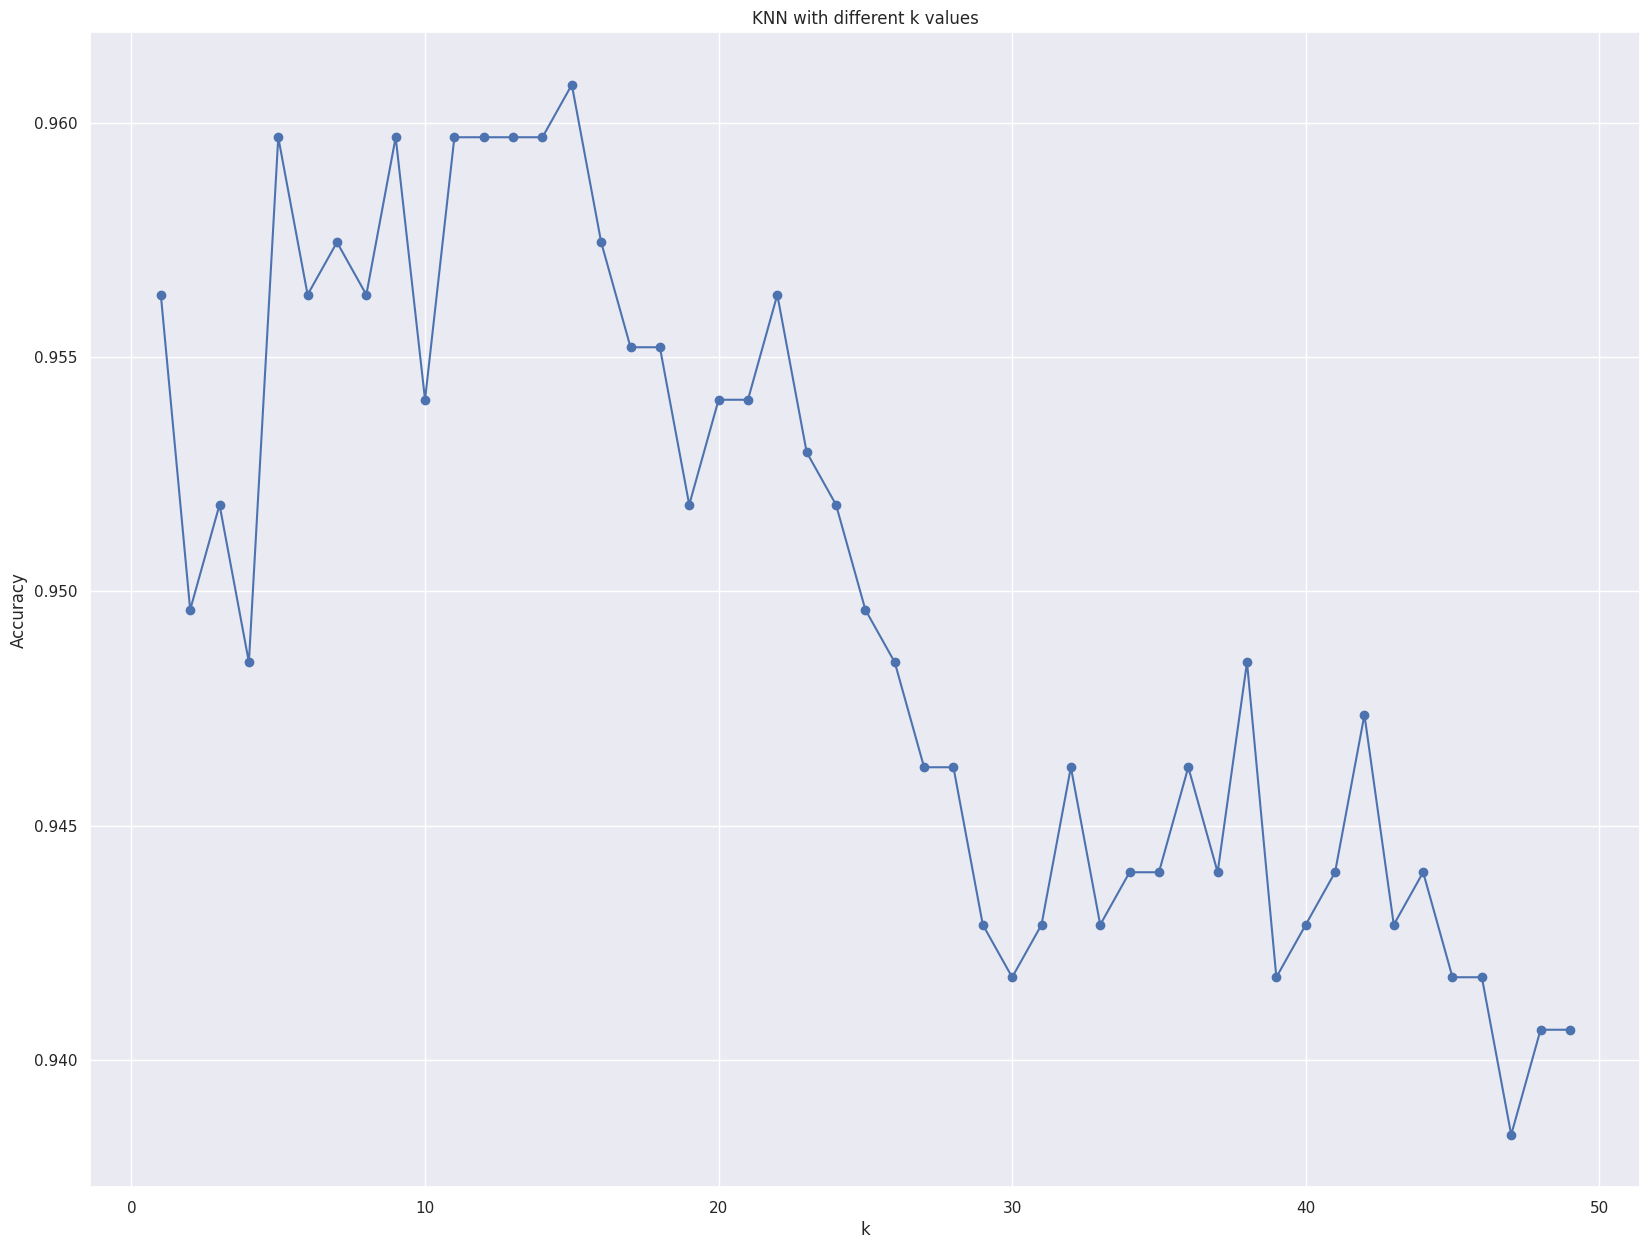

              precision    recall  f1-score   support

           0       0.91      0.90      0.91        90
           1       0.96      0.98      0.97       531
           2       0.94      0.85      0.89        72
           3       0.98      0.98      0.98       200

    accuracy                           0.96       893
   macro avg       0.95      0.93      0.94       893
weighted avg       0.96      0.96      0.96       893

[[ 81   9   0   0]
 [  8 520   1   2]
 [  0   9  61   2]
 [  0   1   3 196]]


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

X_knn = dataset[['Day', 'CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total']]
y_knn = dataset['Trafficst']

Xknn_train, Xknn_test, yknn_train, yknn_test = train_test_split(X_knn, y_knn, test_size=0.3, random_state=30)

krange = range(1, 50)
acc_scores = []

for k in krange:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(Xknn_train, yknn_train)
    yknnhat = knn.predict(Xknn_test)
    acc = accuracy_score(yknn_test, yknnhat)
    acc_scores.append(acc)

plt.plot(krange, acc_scores, marker='o')
plt.title('KNN with different k values')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.show()

best_knn = KNeighborsClassifier(n_neighbors=15)
best_knn.fit(Xknn_train, yknn_train)
new_yknnhat = best_knn.predict(Xknn_test)

print(classification_report(yknn_test, new_yknnhat))
print(confusion_matrix(yknn_test, new_yknnhat))
